In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pandas as pd
from matplotlib import gridspec
import math
from scipy.optimize import curve_fit

Data_Folder = "Test"
Data_Folder_2 = "Test_2"
Test_Files = glob.glob(os.path.join(Data_Folder, "*", "test.txt"))[2:]
Test_Files_2 = glob.glob(os.path.join(Data_Folder_2, "*", "ECRAM_Group1_20250610.txt"))

In [2]:
def Load_Files(file_locations, start, end = None):
    """
    start: <int> OR <array>, start index of desired range or array of desired indexes
    end: <int> end index of desired range (not included)
    """
    if type(start) == int:
        df =  pd.read_csv(file_locations[start], sep="\t", header = 9)

        if type(end) == int:
            for file in file_locations[start+1:end]:
                df = pd.concat([df, pd.read_csv(file, sep="\t", header = 9)], ignore_index=True)
    else:
        df = pd.read_csv(file_locations[start[0]], sep="\t", header = 9)
        for index in start[1:]:
            df = pd.concat([df, pd.read_csv(file_locations[index], sep="\t", header = 9)], ignore_index=True)

    return df

df = Load_Files(Test_Files_2, 0)

In [3]:
def Group_Gate_Voltage(df):

    # Step 1: Create a sign label
    df['label'] = df['Gate Voltage (V)'].apply(lambda x: 'positive' if x > 0.001 else 'zero' if -0.001 < x < 0.001 else 'negative')
    # Step 2: Mark boundaries between different labels
    df['group'] = (df['label'] != df['label'].shift()).cumsum()
    df['FileNr'] = (df['Time (s)'] == 0).cumsum()
    df['Prev-V'] = ''
    # Step 3: Post-process zero groups
    group_labels = df.groupby('group')['label'].first()
    group_voltages = df.groupby('group')['Gate Voltage (V)'].first()
    # Create mapping: group_id → new label
    new_labels = {}
    new_voltage = {}
    
    for (group_id, label), (_, V) in zip(group_labels.items(), group_voltages.items()):
        if label == 'zero':
            prev_label = group_labels.get(group_id - 1, None)
            prev_voltage = group_voltages.get(group_id - 1, None)
            new_voltage[group_id] = prev_voltage
            if prev_label == 'positive':
                new_labels[group_id] = 'zero-p'
                
            elif prev_label == 'negative':
                new_labels[group_id] = 'zero-n'
            else:
                new_labels[group_id] = 'zero'  # fallback
        else:
            new_labels[group_id] = label
    
    # Apply new labels
    df['label'] = df['group'].map(new_labels)
    df['Prev-V'] = df['group'].map(new_voltage)

    
    df = df.drop(df[df['Time (s)']<0.001].index)
    return df

df = Group_Gate_Voltage(df)

def Disp_Group(df, limit=np.inf):
    grouped = df.groupby(['group', 'label'])
    for (group_id, label), group_df in grouped:
        print(f"Group {group_id} ({label}):")
        print(group_df)
        print()
        if group_id > limit:
            break
#Disp_Group(df, 0)

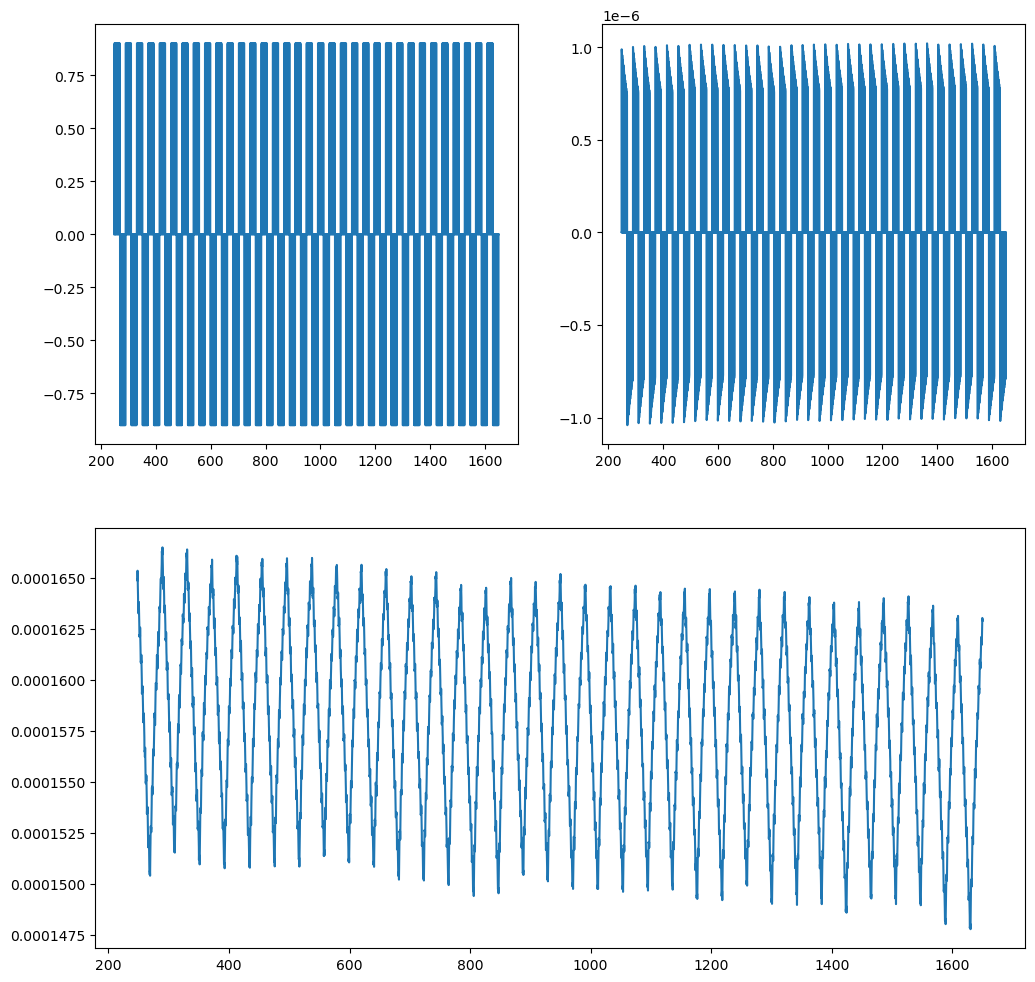

In [4]:
def df_Plot(df, y_range=(None,None), x_range=(None,None)):
    fig = plt.figure(
    figsize = (12, 12))
    gs = gridspec.GridSpec(2, 2)
    
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[1, 0:2])
    grouped = df.groupby(['FileNr'])
    for group_id, group_df in grouped:
        ax1.plot(group_df["Time (s)"], group_df['Gate Voltage (V)'])
        ax2.plot(group_df["Time (s)"], group_df['Gate Current (A)'])
        ax3.plot(group_df["Time (s)"], group_df['Drain Current (A)'])
    ax3.set_ylim(ymin=y_range[0], ymax=y_range[1])
    ax3.set_xlim(xmin=x_range[0], xmax=x_range[1])
df_Plot(df)

In [5]:
def Reset_Time(df):
    grouped = df.groupby(['group', 'label'])
    for (group_id, label), group in grouped:
        df.loc[df['group']==group_id, 'Time (s)'] = group['Time (s)']-group['Time (s)'].iloc[0]
    return df

df = Reset_Time(df)
Disp_Group(df, 0)

Group 1 (zero):
   Time (s)  Gate Voltage (V)  Drain Current (A)  Gate Current (A) label  \
0       0.0         -0.000019           0.000165      1.982450e-11  zero   

   group  FileNr  Prev-V  
0      1       0     NaN  



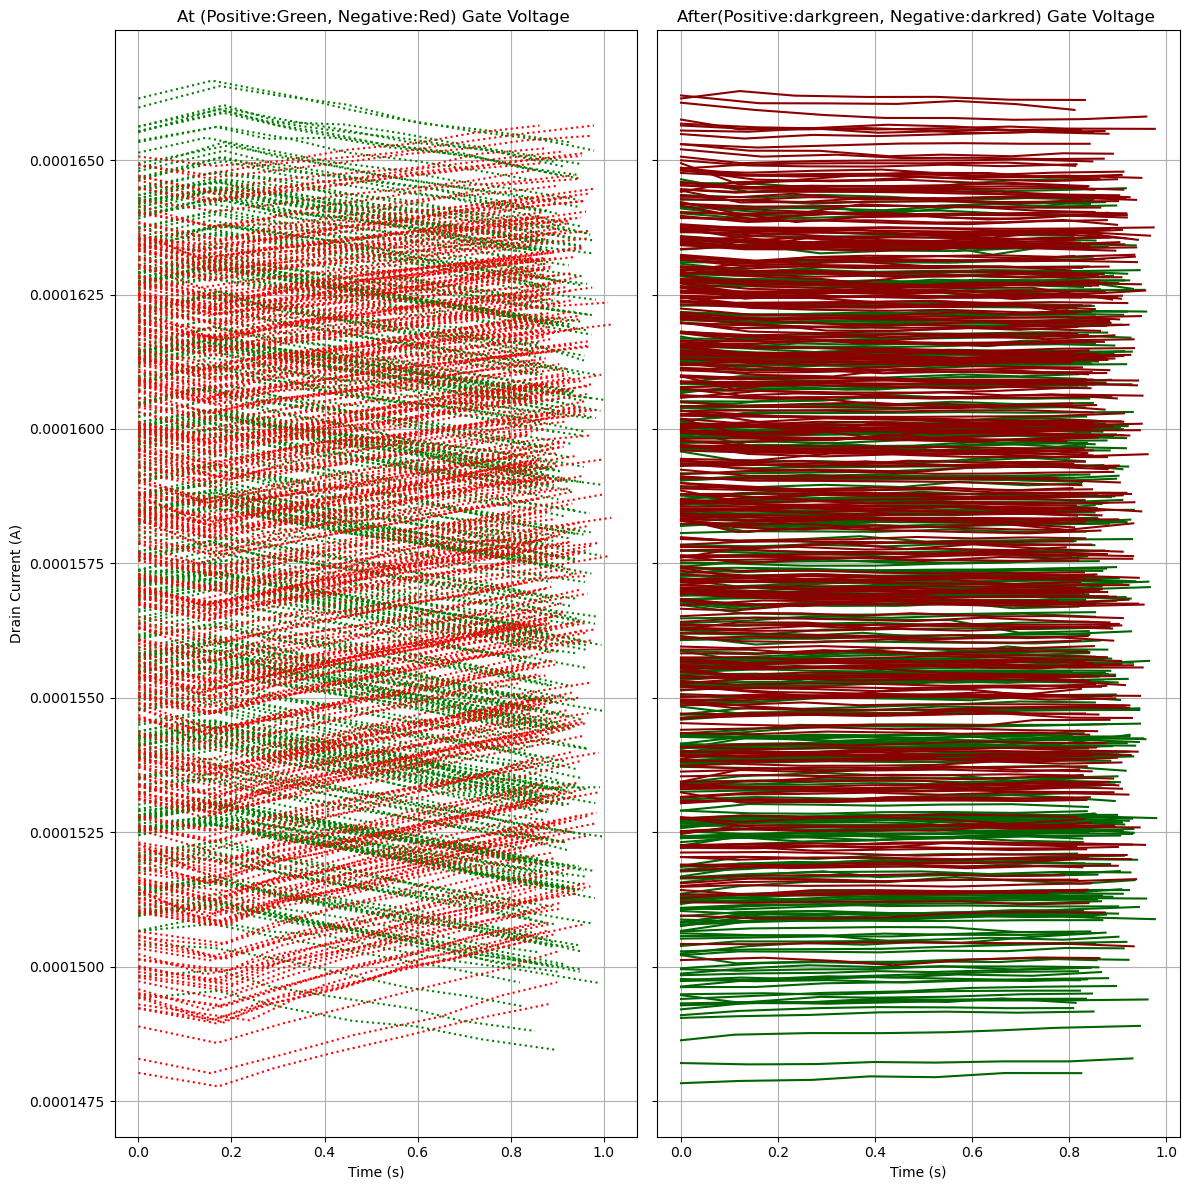

In [6]:
def Plot_Grouped(df, ax, label):
    colors = {'positive': 'green', 'zero-p': 'darkgreen', 'zero-n': 'darkred', 'negative': 'red', 'zero': 'black'}
    linestyles = {'0.0': '-', '0.9': ':', '0.8': ':', '0.3': '--', '0.1': '-.', '0.03':' ', '0.09': '-.', '0.45':'-.'}
    for _, group_df in df[df['label']==label].groupby('group'):
        ax.plot(group_df['Time (s)'], group_df['Drain Current (A)'], 
        label=group_df['label'].iloc[0], 
        color=colors[group_df['label'].iloc[0]],
        linestyle = linestyles[str(round(abs(float(group_df['Gate Voltage (V)'].iloc[0])), 2))])
    



def Plot_Group_df(df, x_range=(None, None), y_range=(None,None)):
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(12, 12), tight_layout = True)\
    
    Plot_Grouped(df, ax1, 'positive')
    Plot_Grouped(df, ax1, 'negative')
    
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Drain Current (A)')
    ax1.set_title('At (Positive:Green, Negative:Red) Gate Voltage ')
    ax1.grid(True)
    
    Plot_Grouped(df, ax2, 'zero-p')
    Plot_Grouped(df, ax2, 'zero-n')
    Plot_Grouped(df, ax2, 'zero')
    
    ax2.set_xlabel('Time (s)')
    ax2.set_title('After(Positive:darkgreen, Negative:darkred) Gate Voltage ')
    ax2.grid(True)
    ax2.set_xlim(xmin = x_range[0], xmax=x_range[1])
    ax2.set_ylim(ymin = y_range[0], ymax=y_range[1])

    plt.show()

Plot_Group_df(df)

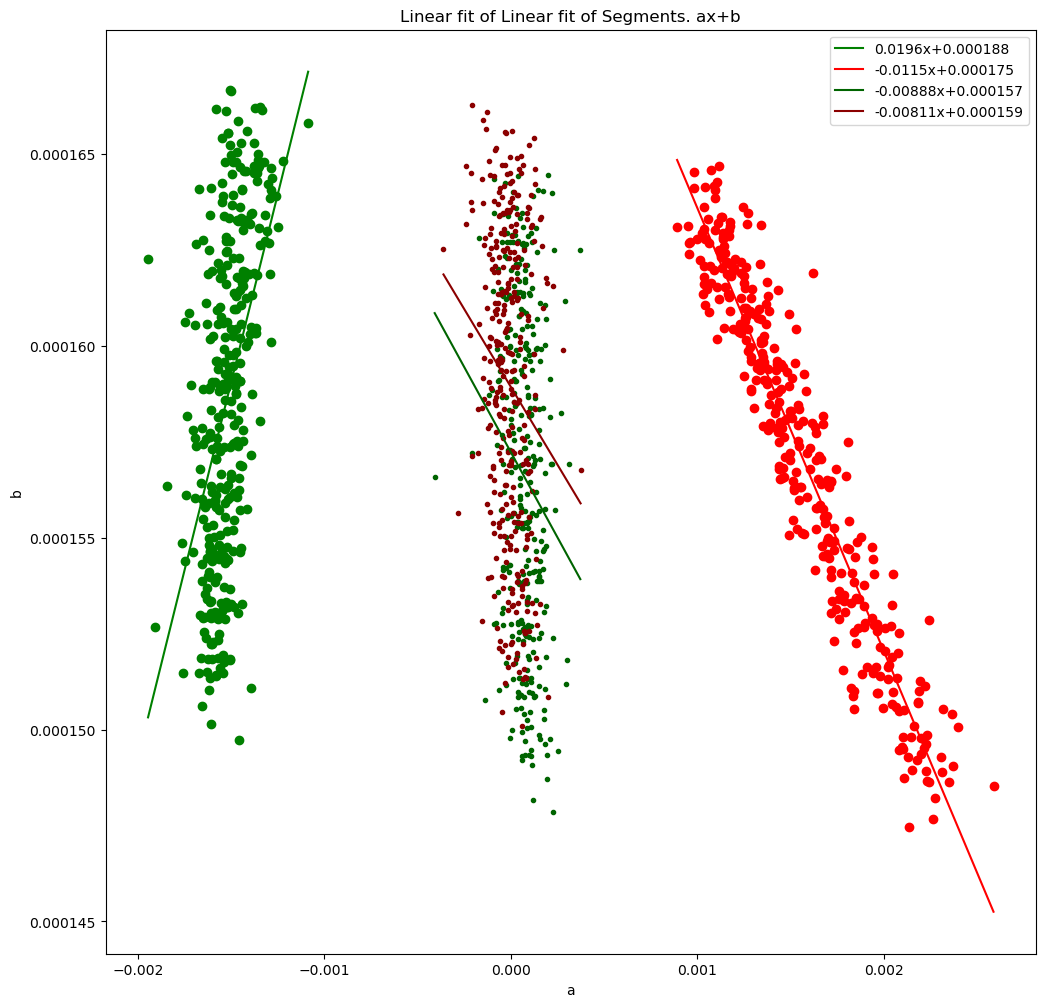

In [7]:
def Lin_Fit(df, label):
    filled_markers = ('.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
    markerstyles = {'0.0': '.', '0.9': 'o', '0.8': 'o', '0.3': 'v', '0.1': 'd', '0.03':'*', '0.45': 'd'}
    fit_m = []
    fit_b = []
    voltage = []
    
    for _, group_df in df[df['label']==label].groupby('group'):
        if group_df.shape[0] > 1:
            group_df['Time (s)'] = group_df['Time (s)']
            #group_df = group_df.iloc[1:]
            m, b = np.polyfit(group_df['Time (s)'].iloc[1:], group_df['Drain Current (A)'].iloc[1:], 1)
            fit_m.append(m)
            fit_b.append(b)
            voltage.append(str(round(abs(float(group_df['Gate Voltage (V)'].iloc[0])), 2)))
    markerstyle = np.vectorize(markerstyles.get)(voltage)

    return fit_m, fit_b, markerstyle
    
    
def Plot_Lin_Fit_All(df):
    lin_col = ['green', 'red', 'darkgreen', 'darkred', 'black']
    colors = {'positive': 'green', 'zero-p': 'darkgreen', 'zero-n': 'darkred', 'negative': 'red', 'zero': 'black'}
    fig = plt.figure(figsize = (12,12))
    for label in ['positive', 'negative', 'zero-p', 'zero-n', 'zero']:
        if sum(df['label']==label) > 1:
            fit_m, fit_b, markerstyle = Lin_Fit(df, label)
            for i in range(len(markerstyle)):
                plt.scatter(fit_m[i]*1000, fit_b[i], marker = markerstyle[i], color = colors[label])
            fit_m = np.array(fit_m)*1000
            c, d = np.polyfit(fit_m, fit_b, 1)
            x = np.linspace(min(fit_m),max(fit_m))
            y = x*c+d
            name = str(round(c, 2-int(math.floor(math.log10(abs(c))))))+"x+"+str(round(d, 2-int(math.floor(math.log10(abs(d))))))
            plt.plot(x, y, c=colors[label], label = name)

            
    plt.xlabel("a")
    plt.ylabel("b")
    plt.title("Linear fit of Linear fit of Segments. ax+b")
    plt.legend()
    plt.show()


Plot_Lin_Fit_All(df)

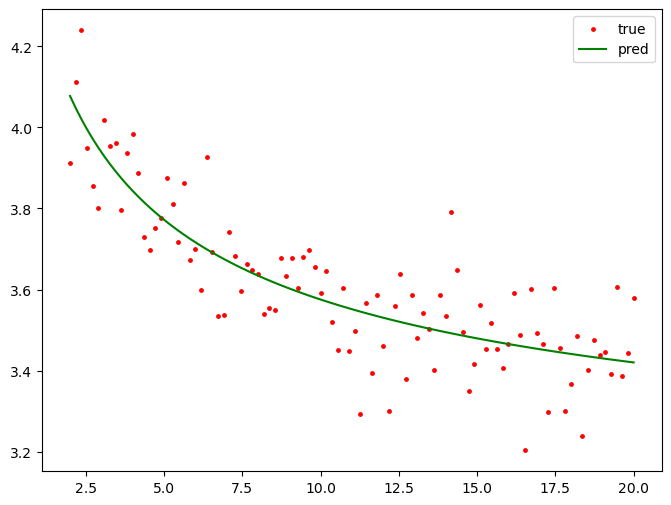

In [8]:


def func(x,a,b,c):
    return a / np.sqrt(x - b) + c

x = np.linspace(2,20,100)
y = func(x,2,-2,3)
y_true = y + 0.1*np.random.normal(size=len(x))

popt, pcov = curve_fit(func,x,y_true)
y_pred = func(x,*popt)

fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(x,y_true,c='r',label='true',s=6)
ax.plot(x,y_pred,c='g',label='pred')
ax.legend(loc='best')

In [9]:
def Plot_Grouped_2(df, label):
    colors = {'positive': 'green', 'zero-p': 'darkgreen', 'zero-n': 'darkred', 'negative': 'red', 'zero': 'black'}
    linestyles = {'0.0': '-', '0.9': ':', '0.8': ':', '0.3': '--', '0.1': '-.', '0.03':' ', '0.09': '-.', '0.45': '-.'}
    for _, group_df in df[df['label']==label].groupby('group'):
        plt.plot(group_df['Drain Current (A)'], group_df['Time (s)'], 
        label=group_df['label'].iloc[0], 
        color=colors[group_df['label'].iloc[0]],
        linestyle = linestyles[str(round(abs(float(group_df['Gate Voltage (V)'].iloc[0])), 2))])


def Plot_Group_df_2(df):
    fig = plt.figure(figsize=(10, 10), tight_layout = True)
    
    Plot_Grouped_2(df, 'positive')
    Plot_Grouped_2(df, 'negative')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Drain Current (A)')
    plt.title('At (Positive:Green, Negative:Red) Gate Voltage ')
    plt.grid(True)


    plt.show()


def Lin_Fit_2(df, label):
    def lin(x,a,b):
        return a*x + b

    filled_markers = ('.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
    markerstyles = {'0.0': '.', '0.9': 'o', '0.8': 'o', '0.3': 'v', '0.1': 'd', '0.03':'*', '0.45': 'd'}
    fit_a = []
    fit_b = []
    voltage = []
    x = []
    
    for _, group_df in df[df['label']==label].groupby('group'):
        if group_df.shape[0] > 1:
            #group_df['Time (s)'] = group_df['Time (s)']
            #group_df = group_df.iloc[1:]
            #a, b = np.polyfit(group_df['Drain Current (A)'].iloc[1:], group_df['Time (s)'].iloc[1:], 1)
            popt, pcov = curve_fit(lin, group_df['Time (s)'].iloc[1:], group_df['Drain Current (A)'].iloc[1:])
            
            x_i = group_df['Drain Current (A)'].iloc[1]
            fit_a.append(popt[0])
            fit_b.append(popt[1])
            x.append(x_i)
            if label in ['positive', 'negative']:
                voltage.append(str(round(abs(float(group_df['Gate Voltage (V)'].iloc[0])), 2)))
            else:
                voltage.append(str(round(abs(float(group_df['Prev-V'].iloc[0])), 2)))
    markerstyle = np.vectorize(markerstyles.get)(voltage)
    return fit_a, fit_b, x, markerstyle

    

def Gate_Fit(df, label):
    fit_a, fit_b, x, markerstyle = Lin_Fit_2(df, label)
    fit_df = pd.DataFrame(data={'a':fit_a, 'b':fit_b, 'x':x, 'style':markerstyle})
    colors = {'positive': 'green', 'zero-p': 'darkgreen', 'zero-n': 'darkred', 'negative': 'red', 'zero': 'black'}
    grouped = fit_df.groupby('style')
    
    
    fig = plt.figure(figsize=(5, 5), tight_layout = True)
    for _, group_df in grouped:
        style = group_df['style'].values[0]
        group_df = group_df.sort_values(by=['x'])
        popt, pcov = curve_fit(func,group_df['x'],group_df['a'])
        print(style)
        print("a, b, c", popt)
        print("STD Errors", np.sqrt(np.diag(pcov)))
        y_pred = func(group_df['x'],*popt)
        
        
        plt.scatter(group_df['x'], group_df['a'], marker = style, color = colors[label])
        #plt.plot(x_l, y_a)
        plt.plot(group_df['x'], y_pred)
        #plt.show()
    plt.show()
    


In [230]:
def df_Plot(df, y_range=(None,None), x_range=(None,None)):
    fig = plt.figure(figsize = (12, 12))
    gs = gridspec.GridSpec(2, 2)
    
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[1, 0:2])
    grouped = df.groupby(['FileNr'])
    for group_id, group_df in grouped:
        ax1.plot(group_df["Time (s)"], group_df['Gate Voltage (V)'])
        ax2.plot(group_df["Time (s)"], group_df['Gate Current (A)'])
        ax3.plot(group_df["Time (s)"], group_df['Drain Current (A)']*1000)
    fig.tight_layout(pad=2)
    ax3.set_ylim(ymin=y_range[0], ymax=y_range[1])
    ax1.set_xlim(xmin=x_range[0], xmax=x_range[1])
    ax2.set_xlim(xmin=x_range[0], xmax=x_range[1])
    ax3.set_xlim(xmin=x_range[0], xmax=x_range[1])

    ax1.grid()
    ax1.set_title("Applied Voltage Pulses")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Gate Voltage (V)")

    ax2.grid()
    ax2.set_title("Measured Current of Applied Pulses")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Gate Current (A)")

    ax3.grid()
    ax3.set_title("Measured Drain Current")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Drain Current (mA)")
    fig.legend(['±0.9 V Pulse for 1 s', '±0.45 V Pulse for 2s', '±0.3 V Pulse for 3s' ], loc='upper right', bbox_to_anchor=(0.97, 0.96))
    
    
    plt.savefig("Measurement.pdf")

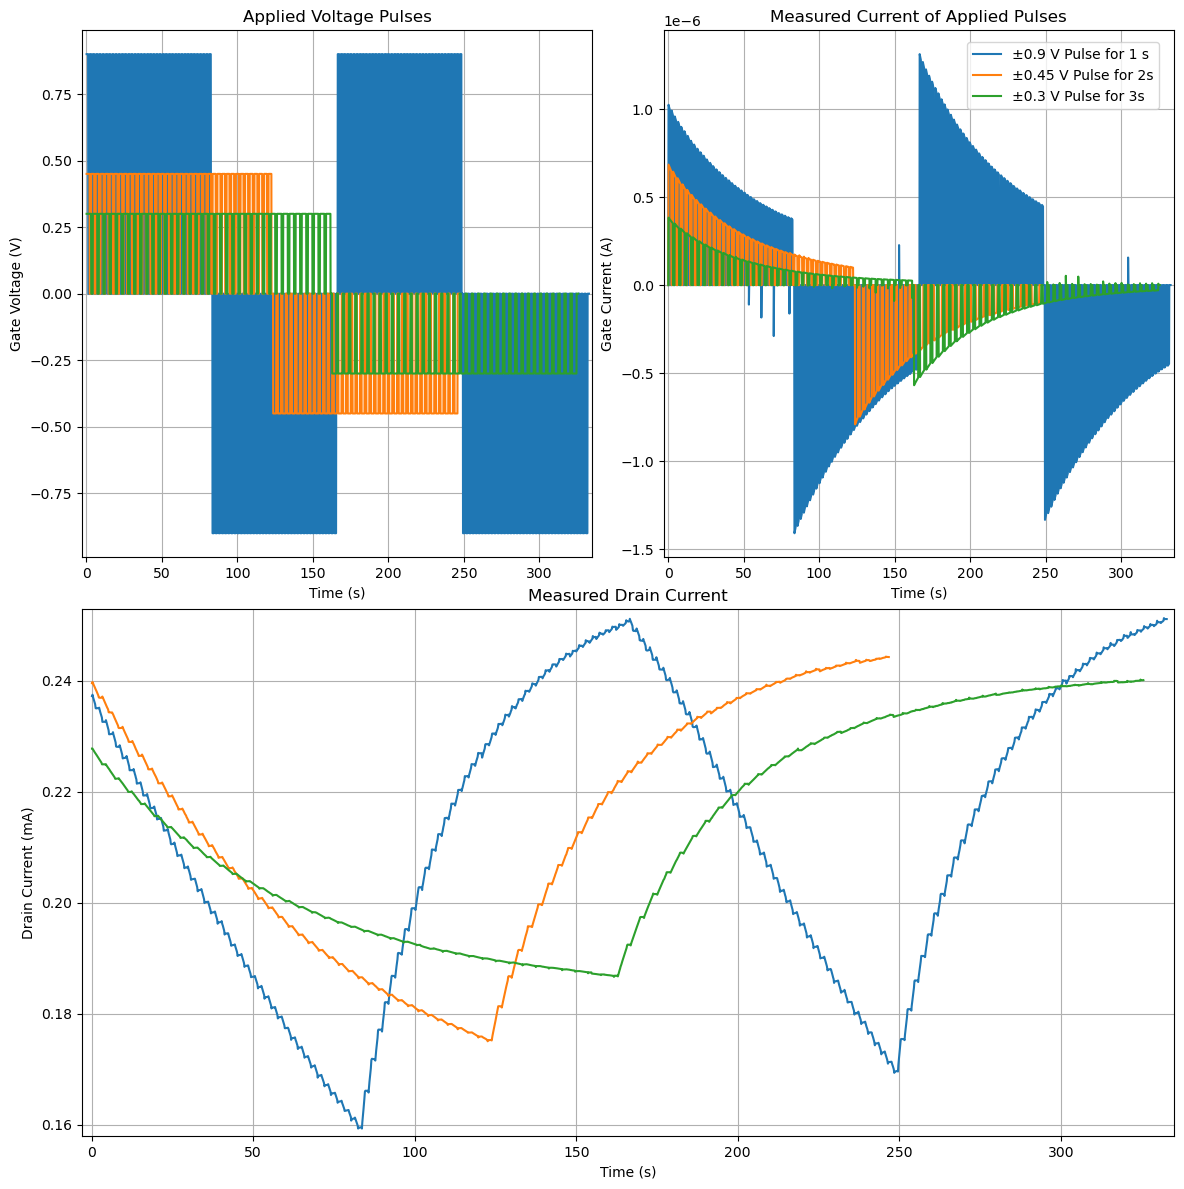

In [231]:
df = Load_Files(Test_Files_2, [3, 7, 6])
df = Group_Gate_Voltage(df)
df_Plot(df, y_range=(0.158,0.253), x_range=(-3,335))

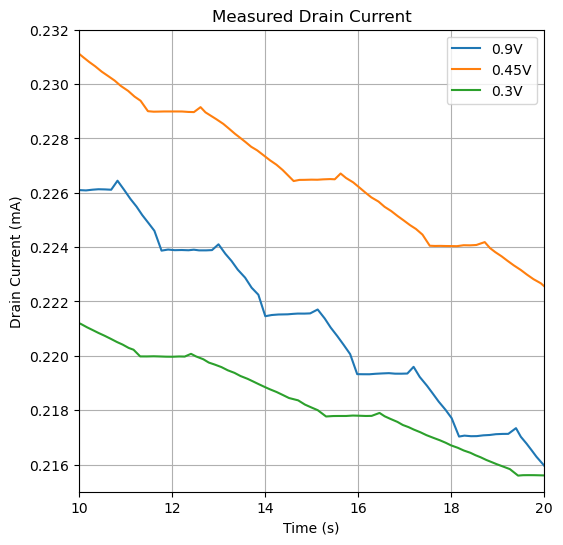

In [130]:
grouped = df.groupby(['FileNr'])
fig = plt.figure(figsize = (6, 6))
for group_id, group_df in grouped:
    
    plt.plot(group_df["Time (s)"], group_df['Drain Current (A)']*1000)
    plt.ylim(ymin=0.215, ymax=0.232)
    plt.xlim(xmin=10, xmax=20)
    plt.grid()
    plt.title("Measured Drain Current")
    plt.xlabel("Time (s)")
    plt.ylabel("Drain Current (mA)")
    plt.legend(["0.9V", "0.45V", "0.3V"])
    plt.savefig("DrainCurrentZoom.pdf")

positive o
a, b, c [ 2.65028370e+02 -1.12005284e-01  9.56899283e-06]
STD Errors [1.84684029e+01 7.60228289e-03 7.73597178e-07]
positive d
a, b, c [ 1.47735029e+02 -7.74527358e-02  8.71291847e-06]
STD Errors [8.78969095e+00 3.61509507e-03 3.68914113e-07]
positive v
a, b, c [ 4.80155874e+01 -4.05292413e-02  5.83039758e-06]
STD Errors [1.05601310e+01 4.32905339e-03 4.42265065e-07]
negative o
a, b, c [ 1.15944204e+02 -1.15700020e-01  2.22463244e-05]
STD Errors [1.38267472e+01 5.88582808e-03 6.18971882e-07]
negative d
a, b, c [ 1.22287678e+02 -9.21124970e-02  1.53613682e-05]
STD Errors [8.92850502e+00 3.83750755e-03 4.09191893e-07]
negative v
a, b, c [ 1.62371063e+02 -1.04453074e-01  1.57623395e-05]
STD Errors [1.43210556e+01 6.24060965e-03 6.76676919e-07]
zero-p o
a, b, c [-7.78162567e+00  1.99715409e-03 -2.16408543e-09]
STD Errors [8.06705047e+00 3.28739635e-03 3.31162066e-07]
zero-p d
a, b, c [-3.55743010e+01  1.40563603e-02 -1.33785212e-06]
STD Errors [9.01863873e+00 3.67732254e-03 3.72

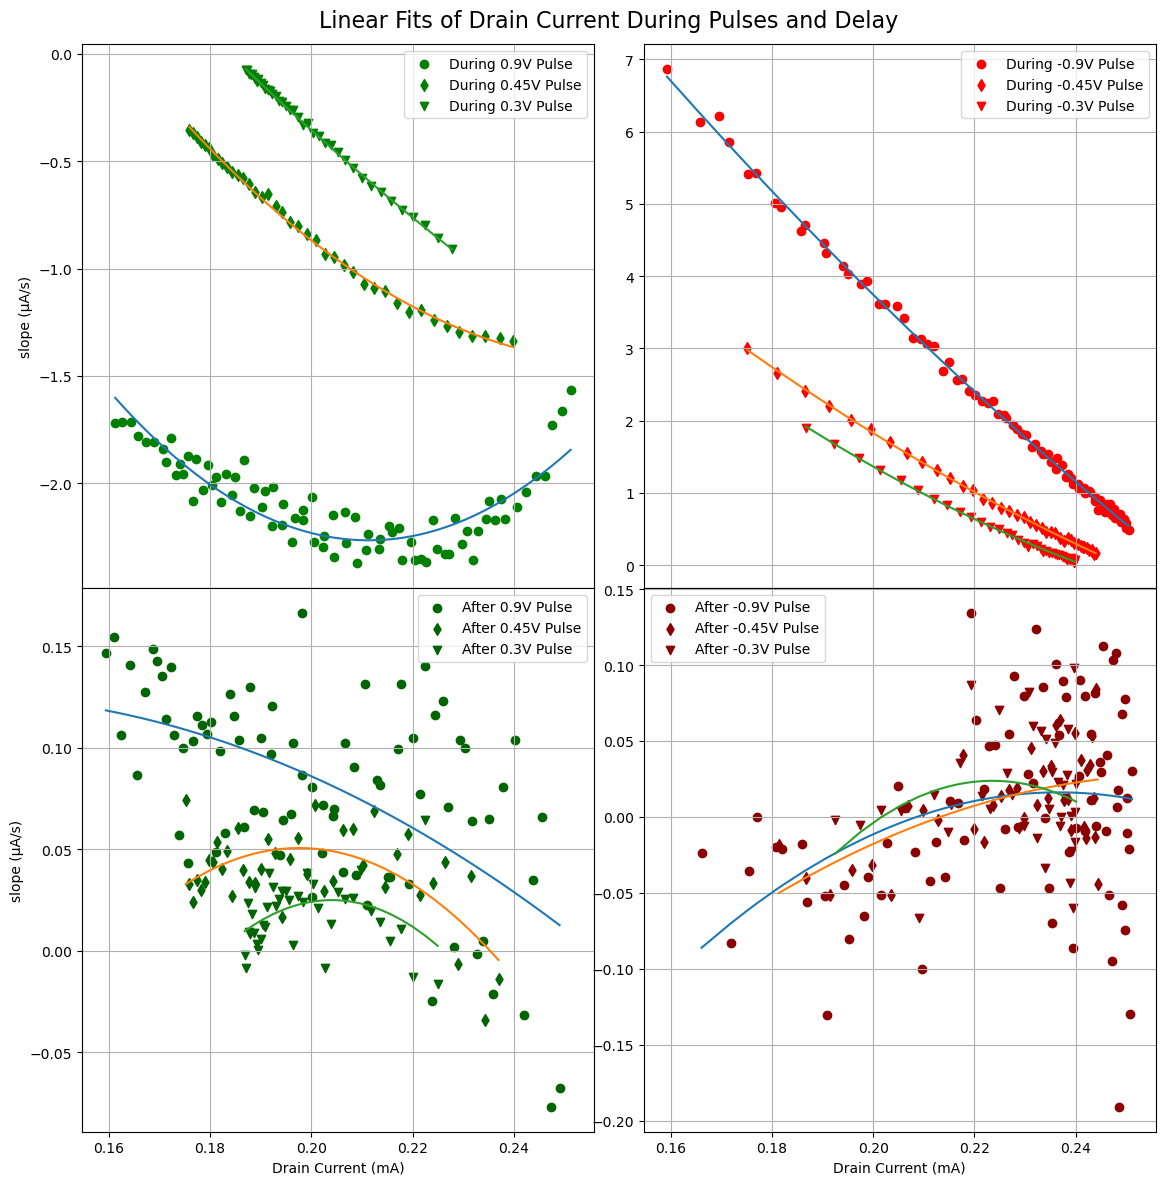

In [233]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'),
                   Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='g', markersize=15),
                   Patch(facecolor='orange', edgecolor='r', label='Color Patch')]

def func(x,a,b,c):
    return a*x**2+b*x+c
    
def Gate_Fit(df):
    labels = ['positive', 'negative', 'zero-p', 'zero-n']
    colors = {'positive': 'green', 'zero-p': 'darkgreen', 'zero-n': 'darkred', 'negative': 'red', 'zero': 'black'}
    markerstyles = {'0.0': '.', '0.9': 'o', '0.8': 'o', '0.3': 'v', '0.1': 'd', '0.03':'*', '0.45': 'd'}
    
    fig, axs = plt.subplots(2,2, sharex=True, squeeze=True)
    fig.set_figheight(12)
    fig.set_figwidth(12)
    fig.tight_layout(pad=3, h_pad=-1, w_pad=0.5)
    for index, label in enumerate(labels):
        fit_a, fit_b, x, markerstyle = Lin_Fit_2(df, label)
        fit_df = pd.DataFrame(data={'a':fit_a, 'b':fit_b, 'x':x, 'style':markerstyle})
        
        grouped = fit_df.groupby('style', sort=False)
        
        for _, group_df in grouped:
            style = group_df['style'].values[0]
            group_df = group_df.sort_values(by=['x'])
            popt, pcov = curve_fit(func,group_df['x'],group_df['a'])
            print(label, style)
            print("a, b, c", popt)
            print("STD Errors", np.sqrt(np.diag(pcov)))
            y_pred = func(group_df['x'],*popt)
            
            
            axs[math.floor(index/2),index%2].scatter(group_df['x']*1000, group_df['a']*1000000, marker = style, color = colors[label])
            axs[math.floor(index/2),index%2].plot(group_df['x']*1000, y_pred*1000000, label='_nolegend_')

    for ax in axs.flat:
        ax.grid()


    
    axs[0,0].set(ylabel='slope (µA/s)')
    axs[1,0].set(xlabel='Drain Current (mA)', ylabel='slope (µA/s)')
    axs[1,1].set(xlabel='Drain Current (mA)')
    #axs[1,1].set(ylabel='y-label')
    #axs.label_outer()
    fig.suptitle("Linear Fits of Drain Current During Pulses and Delay", fontsize=16, y=0.99)
    # Create the figure
    
    axs[0,0].legend(['During 0.9V Pulse','During 0.45V Pulse','During 0.3V Pulse'])
    axs[0,1].legend(['During -0.9V Pulse','During -0.45V Pulse','During -0.3V Pulse'])
    axs[1,0].legend(['After 0.9V Pulse','After 0.45V Pulse','After 0.3V Pulse'])
    axs[1,1].legend(['After -0.9V Pulse','After -0.45V Pulse','After -0.3V Pulse'])

    plt.savefig("Slope.pdf")
    
    plt.show()
    
df = Reset_Time(df)
Gate_Fit(df)


d
a, b, c [ 1.22287678e+02 -9.21124970e-02  1.53613682e-05]
STD Errors [8.92850502e+00 3.83750755e-03 4.09191893e-07]
o
a, b, c [ 1.15944204e+02 -1.15700020e-01  2.22463244e-05]
STD Errors [1.38267472e+01 5.88582808e-03 6.18971882e-07]
v
a, b, c [ 1.62371063e+02 -1.04453074e-01  1.57623395e-05]
STD Errors [1.43210556e+01 6.24060965e-03 6.76676919e-07]


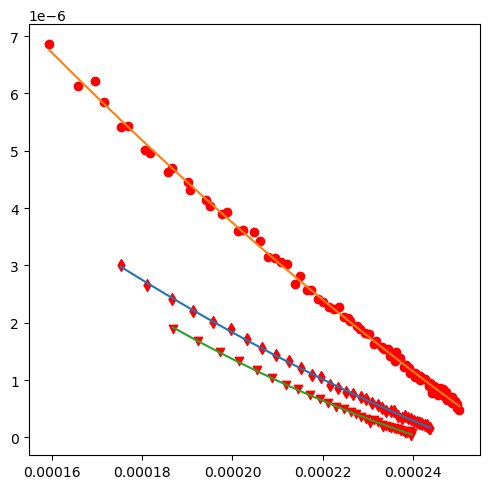

d
a, b, c [ 1.47735029e+02 -7.74527358e-02  8.71291847e-06]
STD Errors [8.78969095e+00 3.61509507e-03 3.68914113e-07]
o
a, b, c [ 2.65028370e+02 -1.12005284e-01  9.56899283e-06]
STD Errors [1.84684029e+01 7.60228289e-03 7.73597178e-07]
v
a, b, c [ 4.80155874e+01 -4.05292413e-02  5.83039758e-06]
STD Errors [1.05601310e+01 4.32905339e-03 4.42265065e-07]


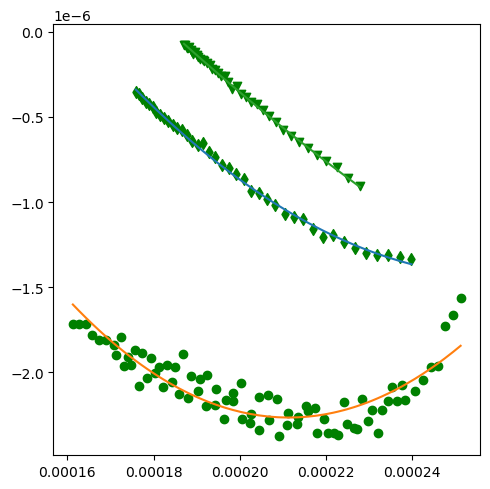

d
a, b, c [-1.23612393e+01  6.44789895e-03 -8.12785123e-07]
STD Errors [1.43931229e+01 6.26601548e-03 6.77682983e-07]
o
a, b, c [-2.05803167e+01  9.73904812e-03 -1.13593249e-06]
STD Errors [1.36741592e+01 5.90549403e-03 6.31137551e-07]
v
a, b, c [-4.98502333e+01  2.22827221e-02 -2.46619375e-06]
STD Errors [3.57435836e+01 1.57499904e-02 1.72863573e-06]


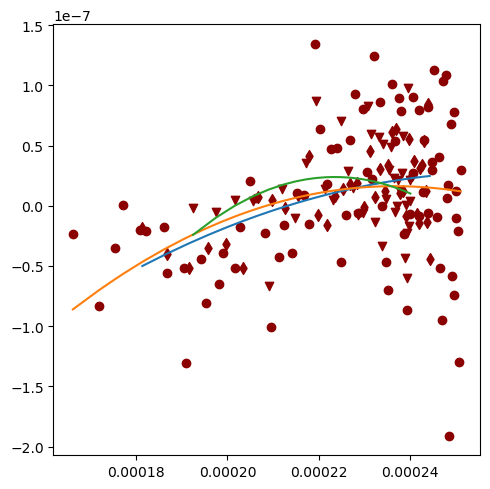

d
a, b, c [-3.55743010e+01  1.40563603e-02 -1.33785212e-06]
STD Errors [9.01863873e+00 3.67732254e-03 3.72186239e-07]
o
a, b, c [-7.78162567e+00  1.99715409e-03 -2.16408543e-09]
STD Errors [8.06705047e+00 3.28739635e-03 3.31162066e-07]
v
a, b, c [-5.15965675e+01  2.10562616e-02 -2.12323543e-06]
STD Errors [2.25727743e+01 9.19173405e-03 9.33109680e-07]


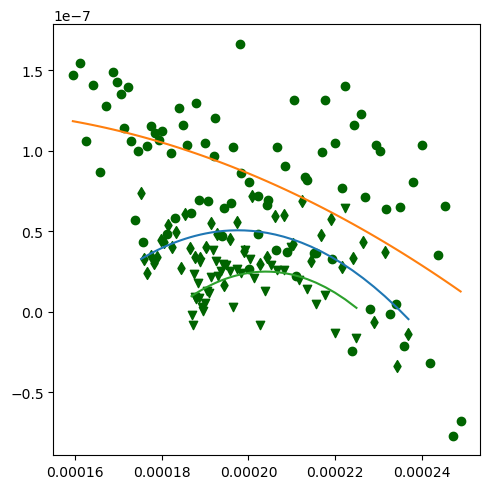

In [11]:


#def func(x,a,b,c):
#    return a / np.sqrt(-x + b) + c
Gate_Fit(df, 'negative')
#def func(x,a,b,c):
#    return a / np.sqrt(x + b) + c
Gate_Fit(df, 'positive')
Gate_Fit(df, 'zero-n')
Gate_Fit(df, 'zero-p')

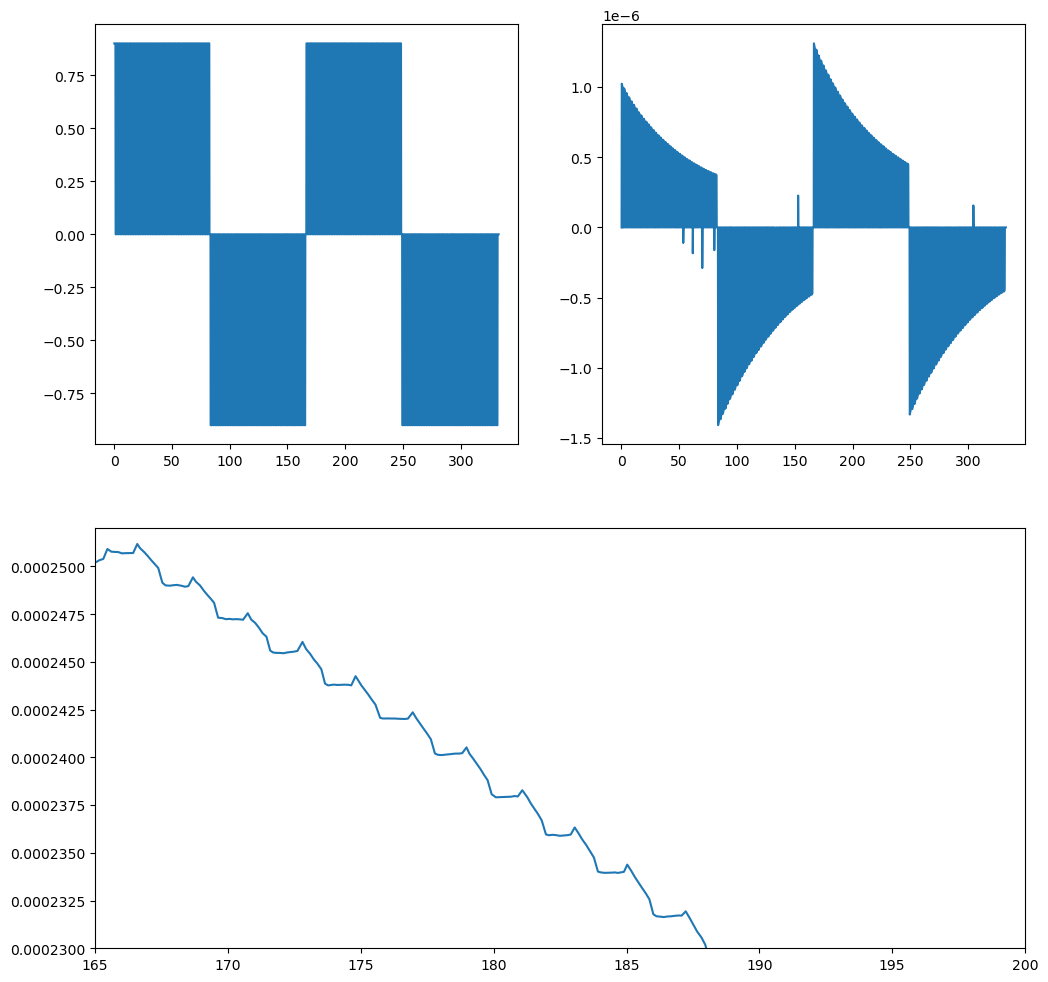

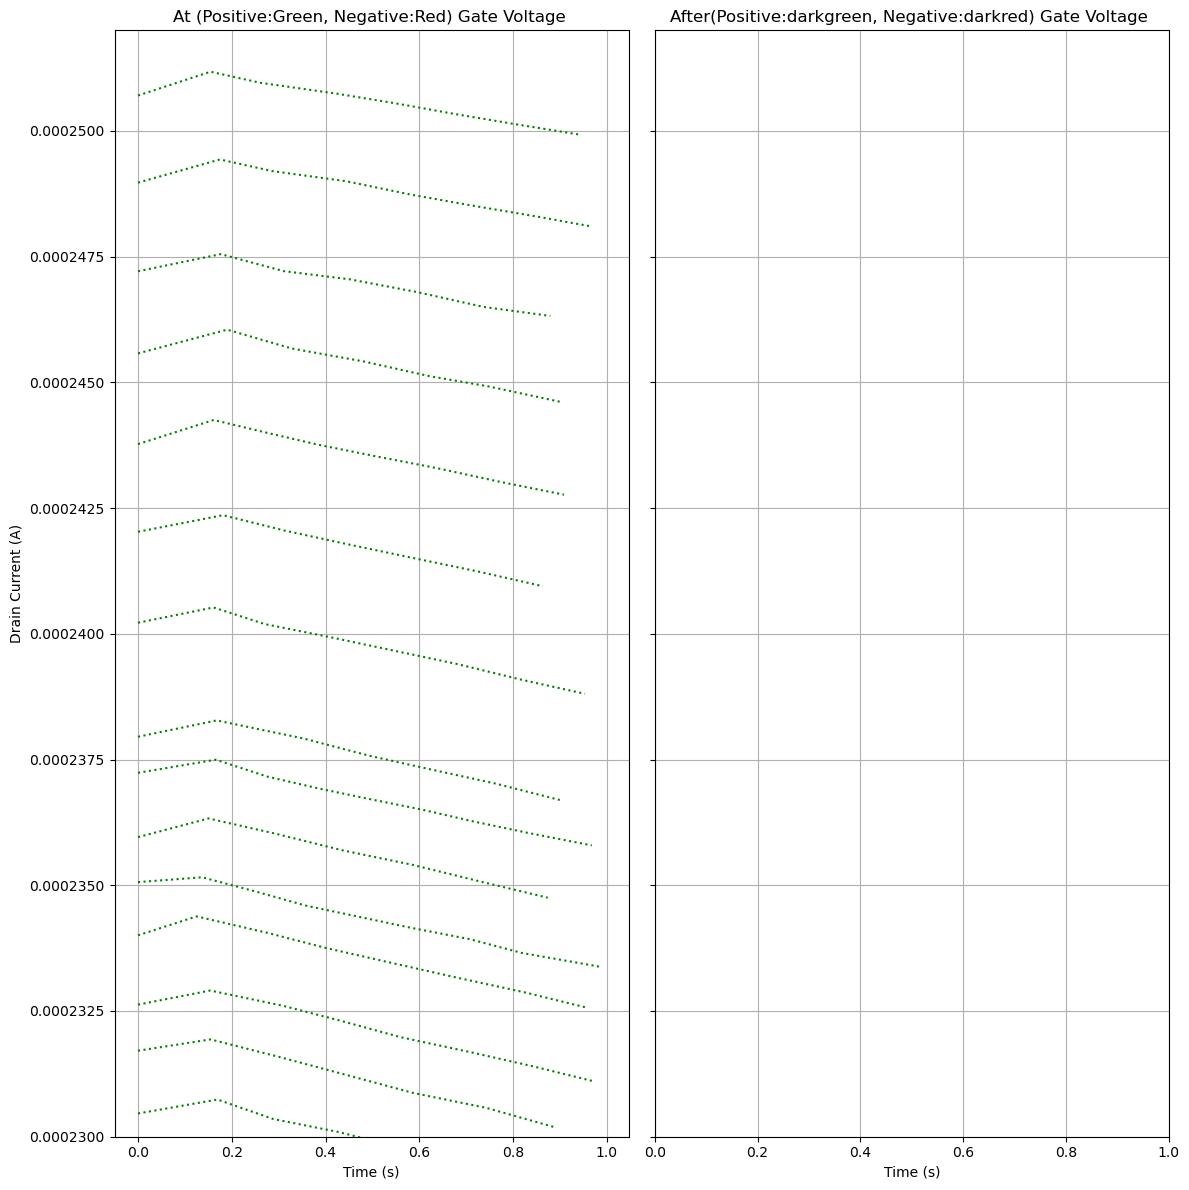

In [115]:
df = Load_Files(Test_Files_2, [3])
df = Group_Gate_Voltage(df)
df_Plot(df, y_range=(0.00023,0.000252), x_range=(165,200))
df = Reset_Time(df[df['Gate Voltage (V)'] > 0.8])
#Disp_Group(df, 0)
Plot_Group_df(df, x_range=(None, None), y_range=(0.00023,0.000252))

In [116]:
df.head()

Time (s)  Gate Voltage (V)  Drain Current (A)  Gate Current (A)     label  \
1  0.000000          0.899900           0.000237     -6.940010e-10  positive   
2  0.165986          0.899903           0.000237      1.023240e-06  positive   
3  0.276024          0.899903           0.000237      1.018930e-06  positive   
4  0.383882          0.899901           0.000237      1.015170e-06  positive   
5  0.488780          0.899902           0.000237      1.011650e-06  positive   

   group  FileNr  
1      2       1  
2      2       1  
3      2       1  
4      2       1  
5      2       1

Group 2 (positive):
    Time (s)  Gate Voltage (V)  Drain Current (A)  Gate Current (A)     label  \
1   0.000000          0.299999           0.000228     -1.926420e-11  positive   
2   0.152307          0.300004           0.000228      3.826880e-07  positive   
3   0.255750          0.300002           0.000228      3.812000e-07  positive   
4   0.370267          0.300002           0.000228      3.797980e-07  positive   
5   0.486646          0.300002           0.000227      3.787240e-07  positive   
6   0.594498          0.300000           0.000227      3.771560e-07  positive   
7   0.705886          0.300000           0.000227      3.757510e-07  positive   
8   0.821561          0.300000           0.000227      3.744860e-07  positive   
9   0.962054          0.300000           0.000227      3.728060e-07  positive   
10  1.105283          0.300000           0.000227      3.710890e-07  positive   
11  1.260066          0.300000           0.000227      3.694750e-07  positive   
12  1.41

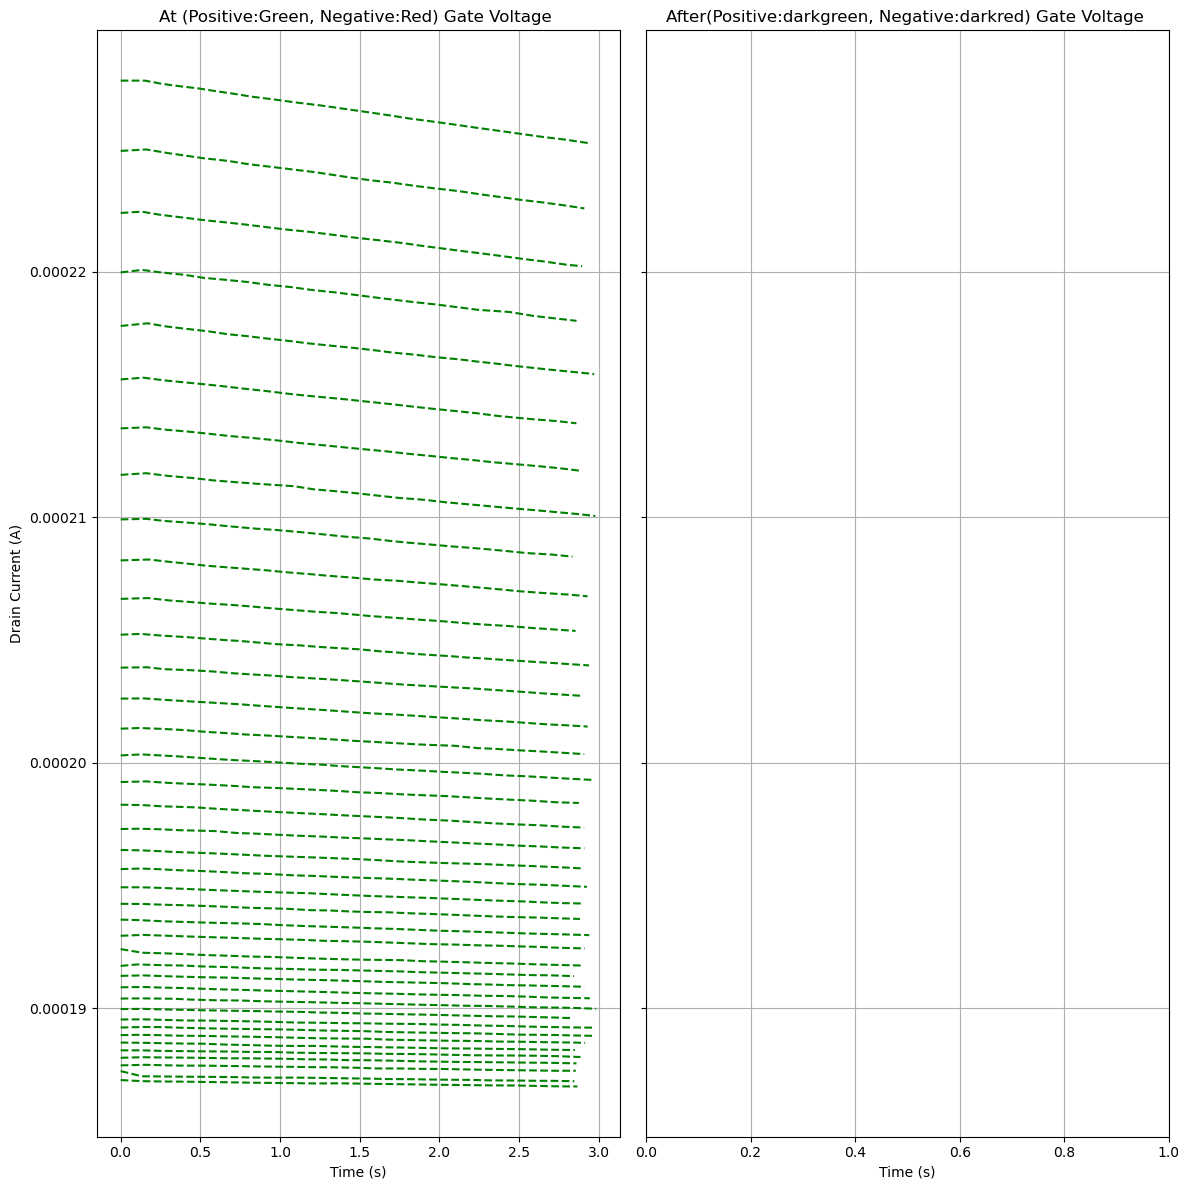

In [76]:
df = Reset_Time(df)
Disp_Group(df, 0)
Plot_Group_df(df)

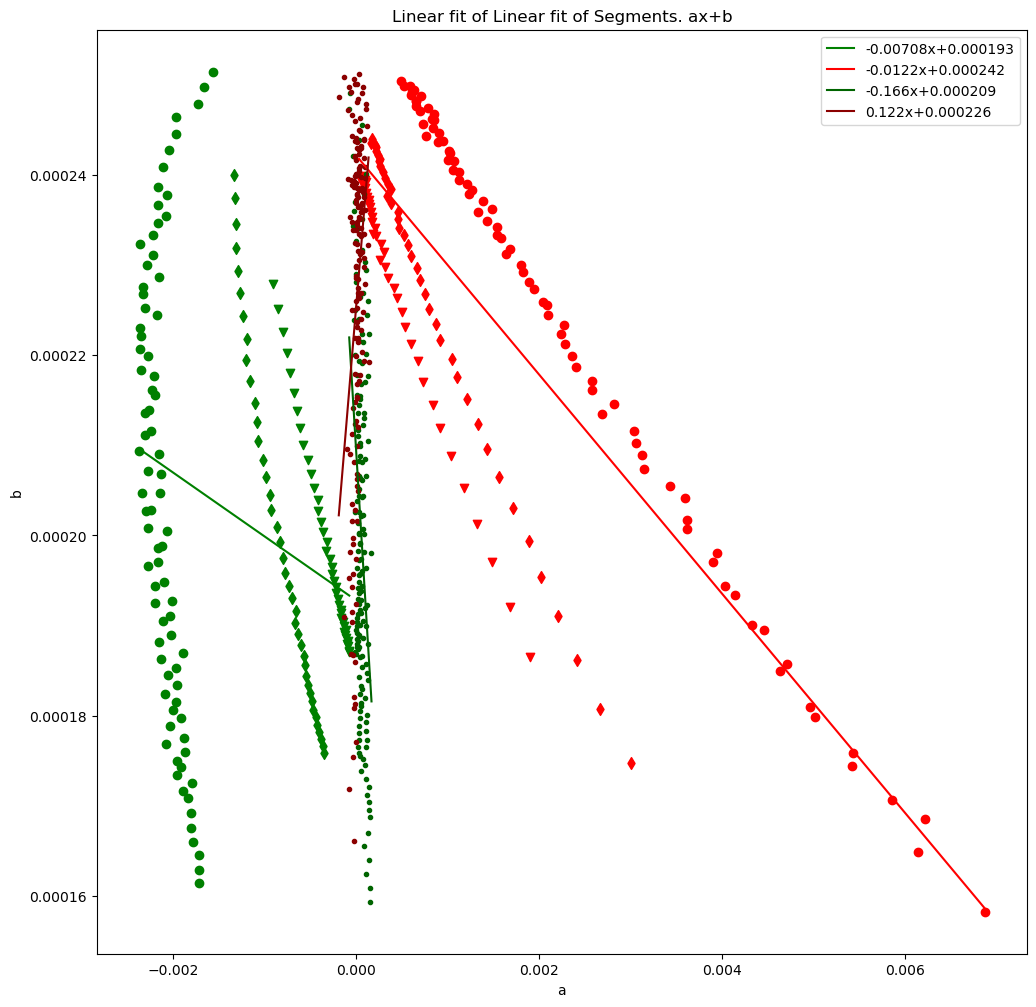

In [73]:
Plot_Lin_Fit_All(df)

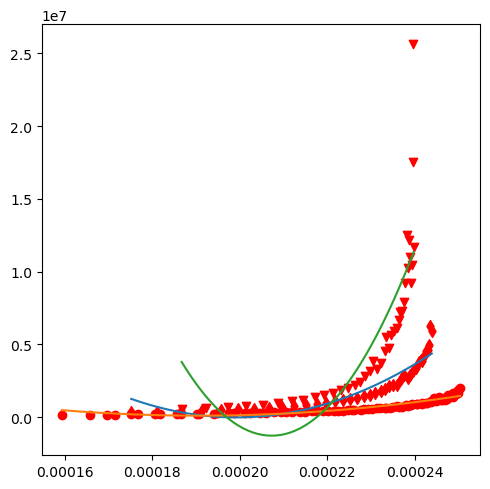

1.1955995648443966e+16 -4957078636862.981 512532655.09308404 -2894784690163.1704 1200424263.5868556 -124106.75221638914


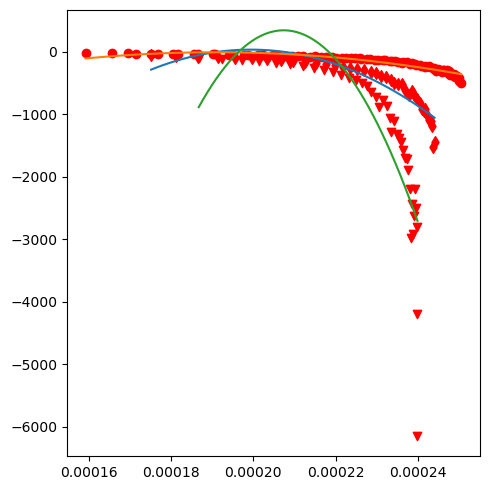

In [16]:
Gate_Fit(df, 'negative')

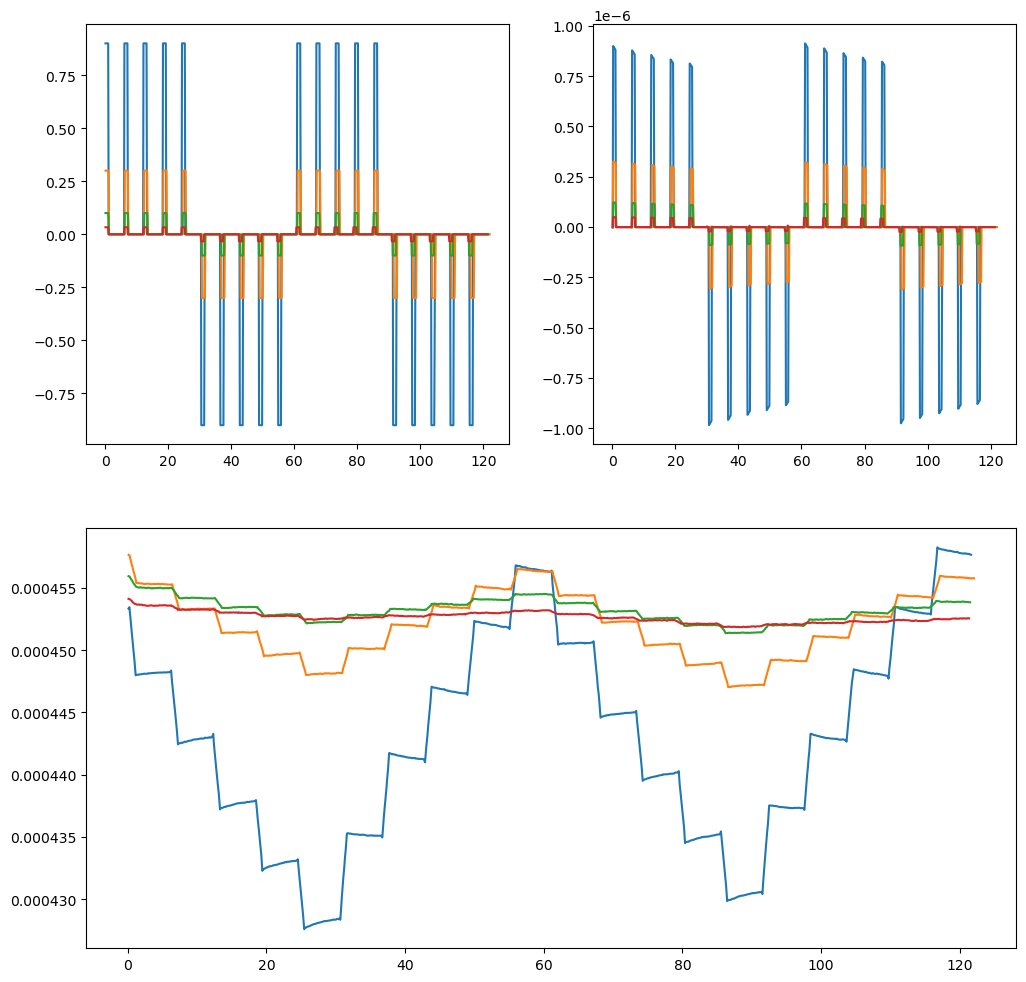

In [11]:
df = Load_Files(4, 8)
df = Group_Gate_Voltage(df)
df_Plot(df)

Group 2 (positive):
   Time (s)  Gate Voltage (V)  Drain Current (A)  Gate Current (A)     label  \
1  0.000000          0.899959           0.000453     -5.334020e-10  positive   
2  0.135127          0.899996           0.000453      8.999220e-07  positive   
3  0.257822          0.899996           0.000453      8.972360e-07  positive   
4  0.381134          0.899997           0.000452      8.939080e-07  positive   
5  0.500843          0.899997           0.000451      8.907160e-07  positive   
6  0.625993          0.899999           0.000451      8.872760e-07  positive   
7  0.741118          0.899998           0.000450      8.843320e-07  positive   
8  0.868137          0.899997           0.000449      8.810040e-07  positive   

   group  FileNr  
1      2       1  
2      2       1  
3      2       1  
4      2       1  
5      2       1  
6      2       1  
7      2       1  
8      2       1  



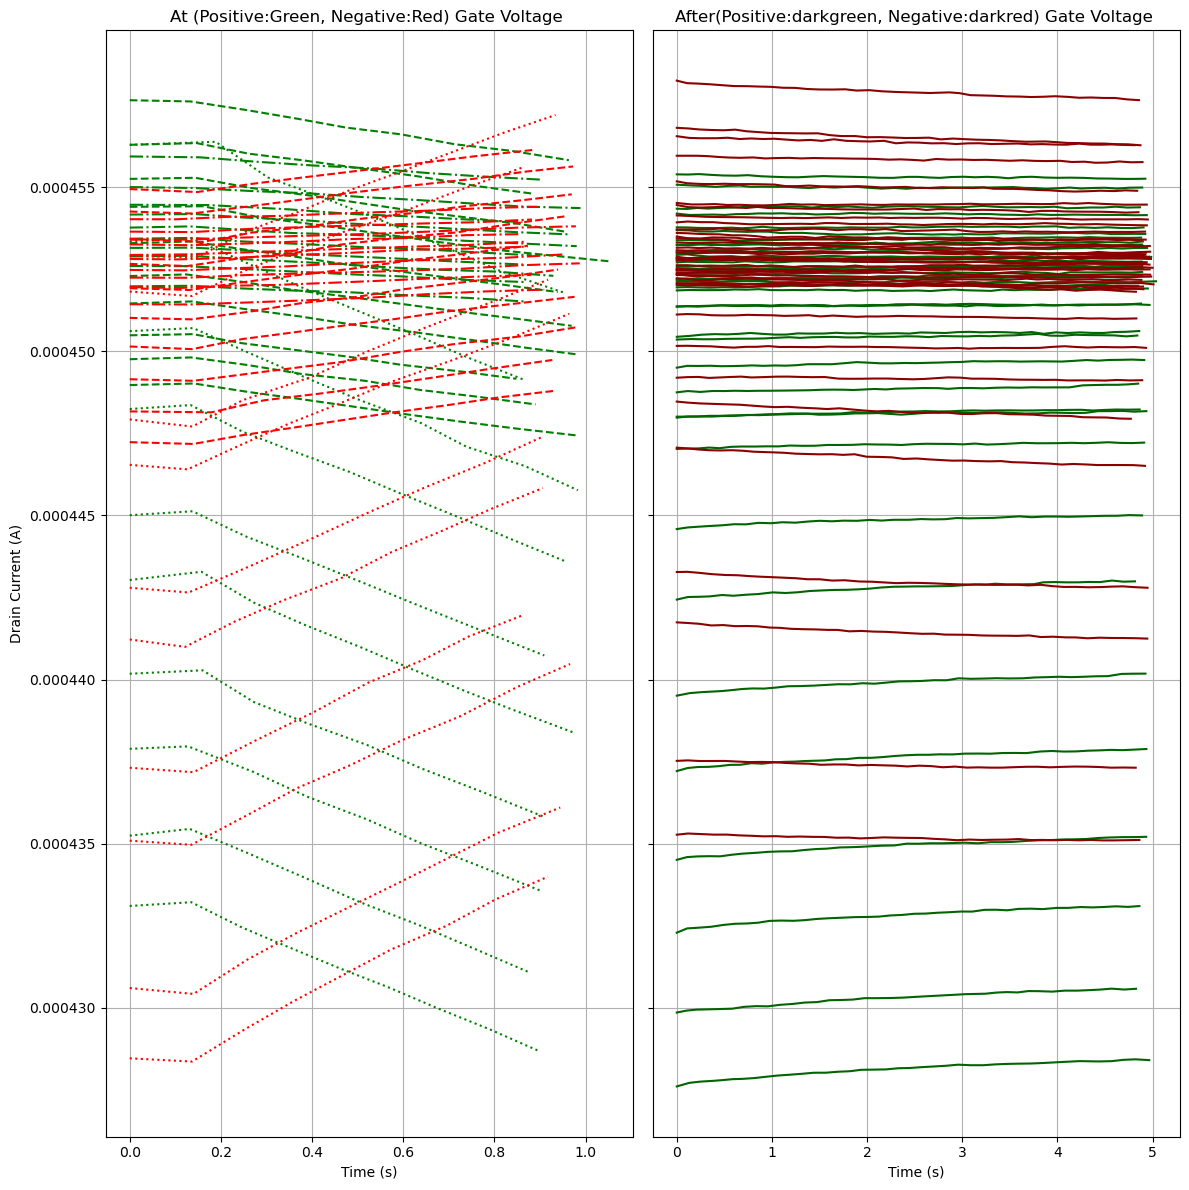

In [12]:
df = Reset_Time(df)
Disp_Group(df, 0)
Plot_Group_df(df)

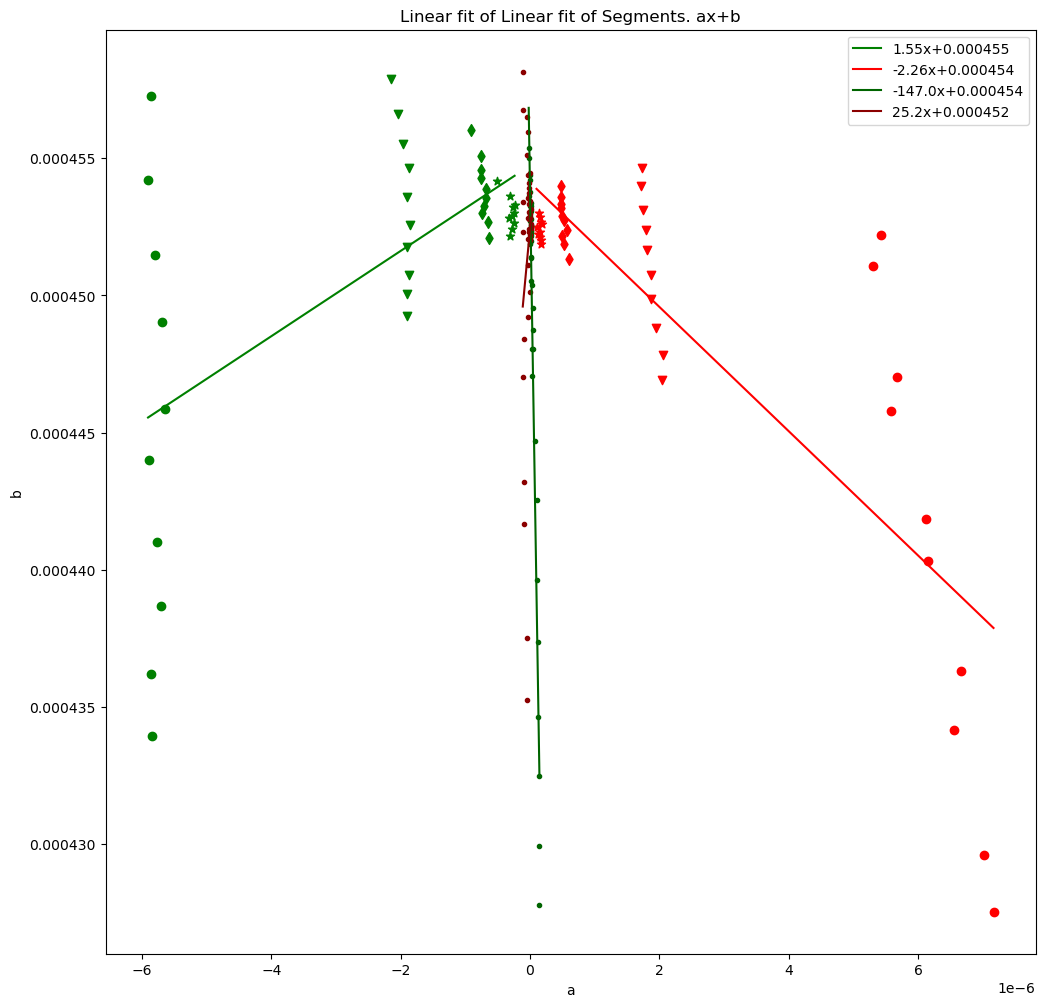

In [13]:
Plot_Lin_Fit_All(df)

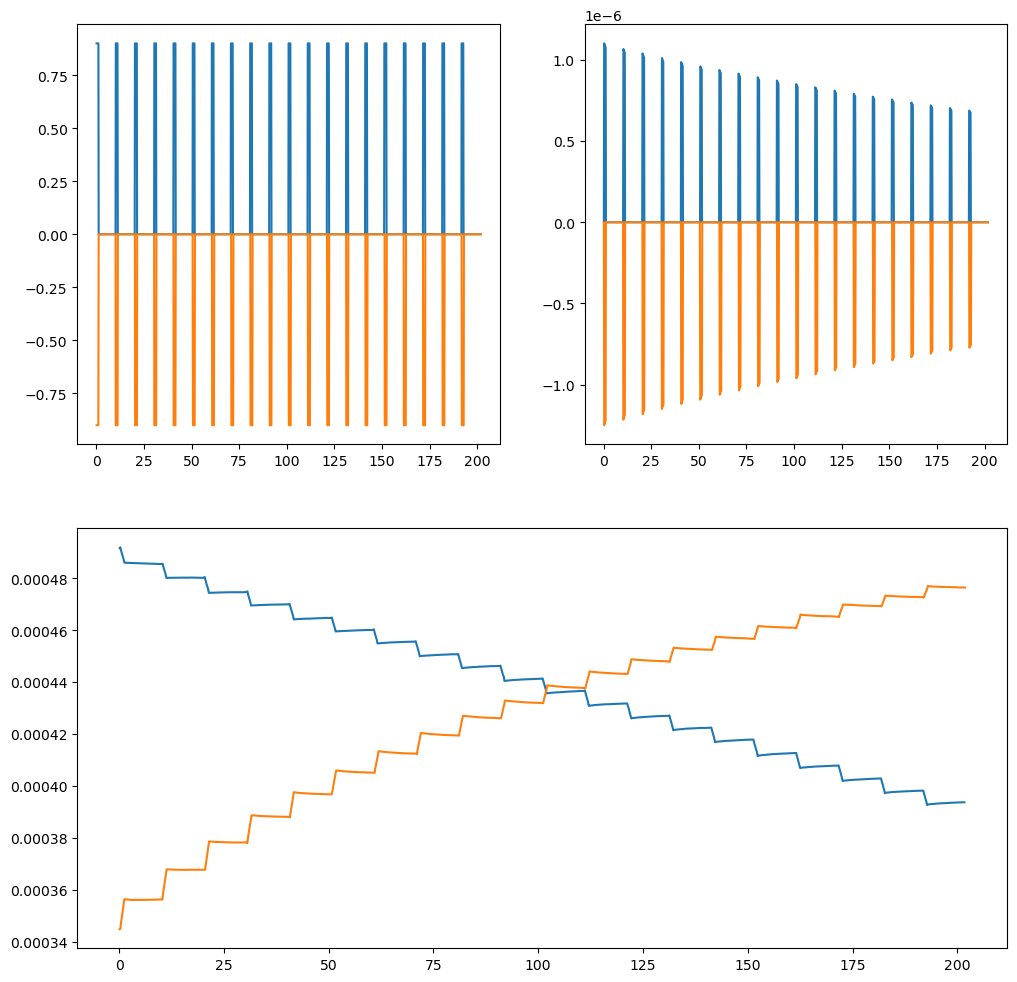

In [19]:
df = Load_Files([9, 11])
df = Group_Gate_Voltage(df)
df_Plot(df)

Group 2 (positive):
   Time (s)  Gate Voltage (V)  Drain Current (A)  Gate Current (A)     label  \
1  0.000000          0.899956           0.000492     -3.400210e-10  positive   
2  0.171075          0.899995           0.000492      1.102020e-06  positive   
3  0.308580          0.899994           0.000491      1.097330e-06  positive   
4  0.424759          0.899994           0.000490      1.093060e-06  positive   
5  0.528767          0.899993           0.000490      1.089430e-06  positive   
6  0.631925          0.899996           0.000489      1.086060e-06  positive   
7  0.742974          0.899994           0.000488      1.082350e-06  positive   
8  0.852470          0.899993           0.000488      1.078860e-06  positive   
9  0.959611          0.899994           0.000487      1.075310e-06  positive   

   group  FileNr  
1      2       1  
2      2       1  
3      2       1  
4      2       1  
5      2       1  
6      2       1  
7      2       1  
8      2       1  
9      2

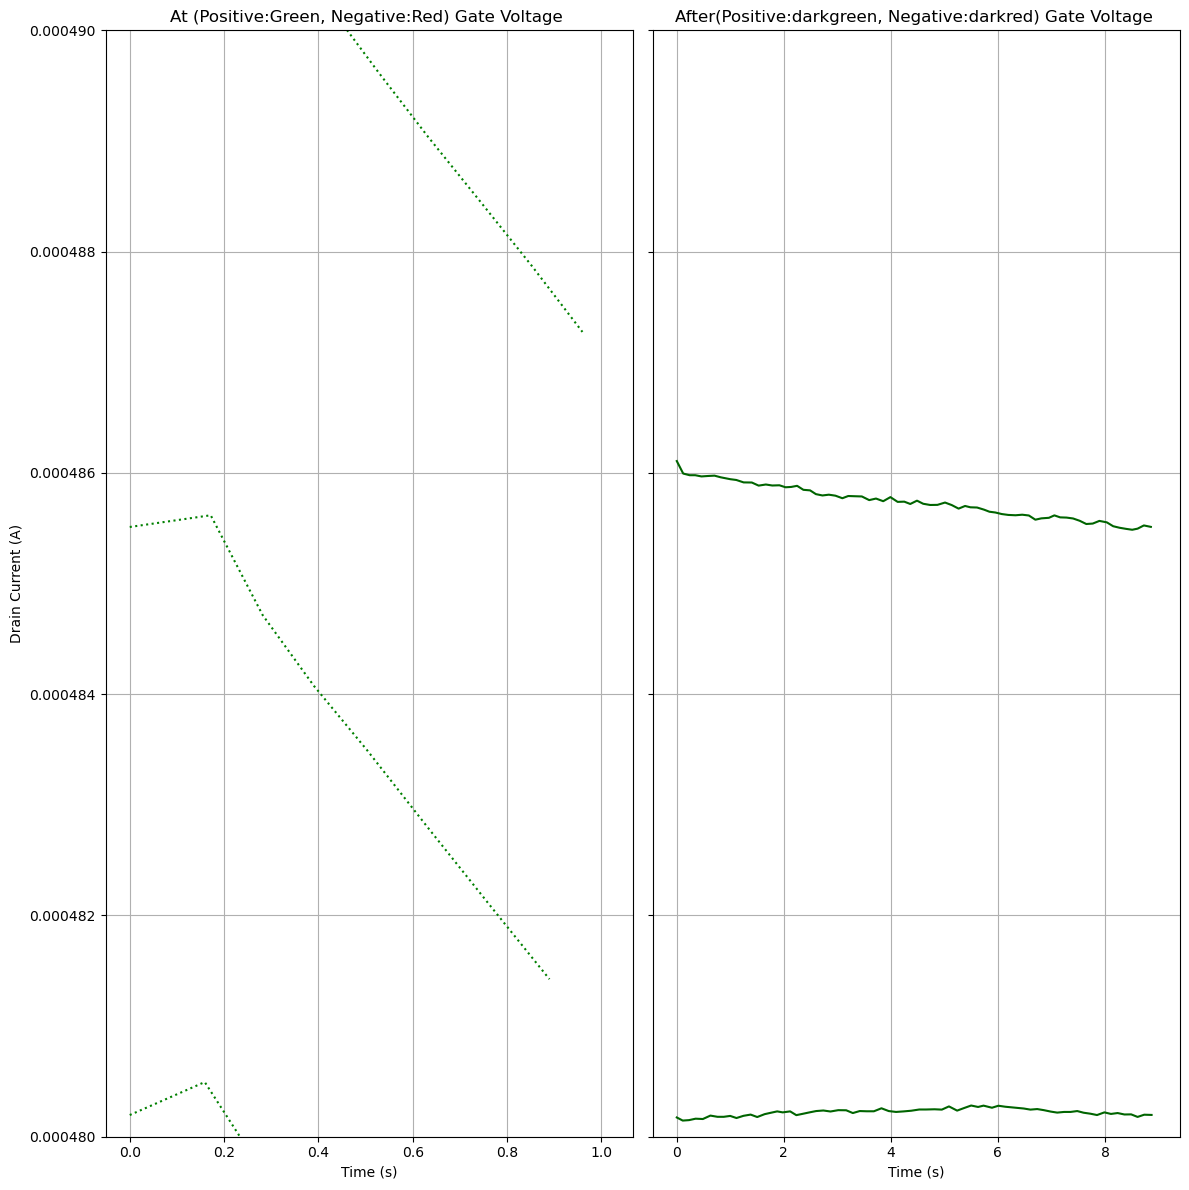

In [24]:
df = Reset_Time(df)
Disp_Group(df, 0)
Plot_Group_df(df, y_range = (0.00048, 0.00049))

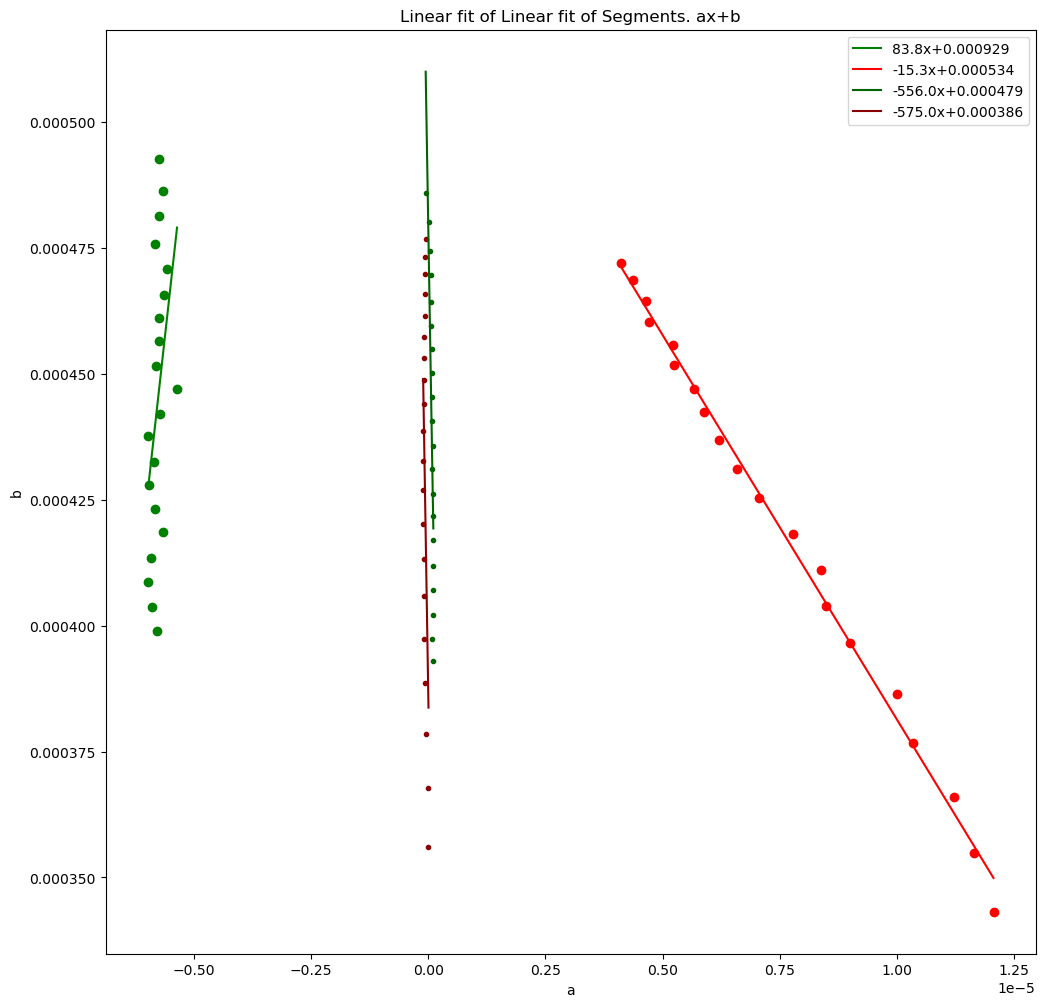

In [82]:
Plot_Lin_Fit_All(df)

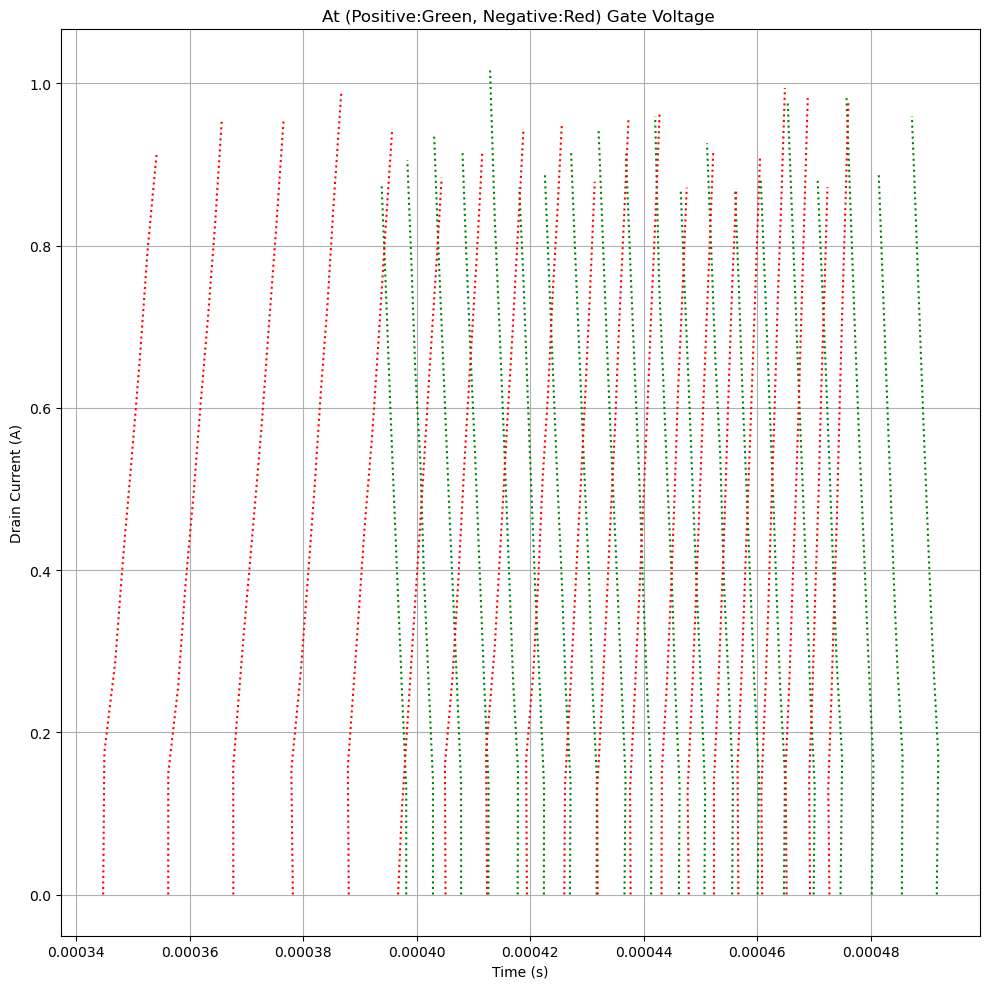

10564503068656.299 -7465828703.32943 1404855.1878150357 -5601890830.1896715 3953921.8487045635 -728.215102293577


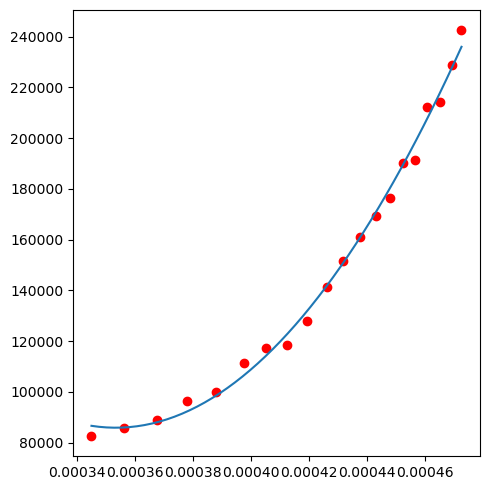

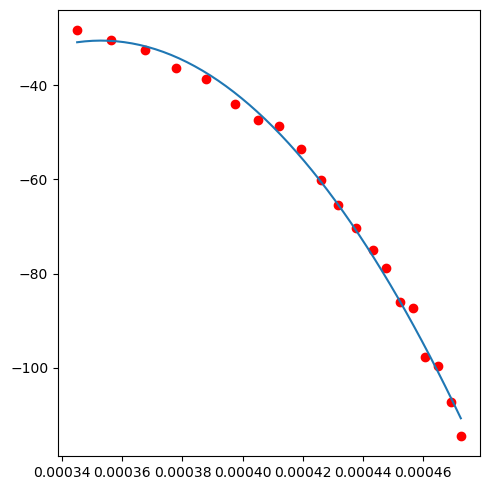

In [83]:
Plot_Group_df_2(df)
label = 'negative'
fit_a, fit_b, x, markerstyle = Lin_Fit_2(df, label)

c, d, k = np.polyfit(x, fit_a, 2)
x_l = np.linspace(min(x),max(x))
y_a = x_l*x_l*c+d*x_l+k
e, f, g = np.polyfit(x, fit_b, 2)
y_b = x_l*x_l*e+f*x_l+g

fig = plt.figure(figsize=(5, 5), tight_layout = True)
for i in range(len(markerstyle)):
    plt.scatter(x[i], fit_a[i], marker = markerstyle[i], color = colors[label])
plt.plot(x_l, y_a)
plt.show
fig = plt.figure(figsize=(5, 5), tight_layout = True)
for i in range(len(markerstyle)):
    plt.scatter(x[i], fit_b[i], marker = markerstyle[i], color = colors[label])
plt.plot(x_l, y_b)
print(c, d, k, e, f, g)

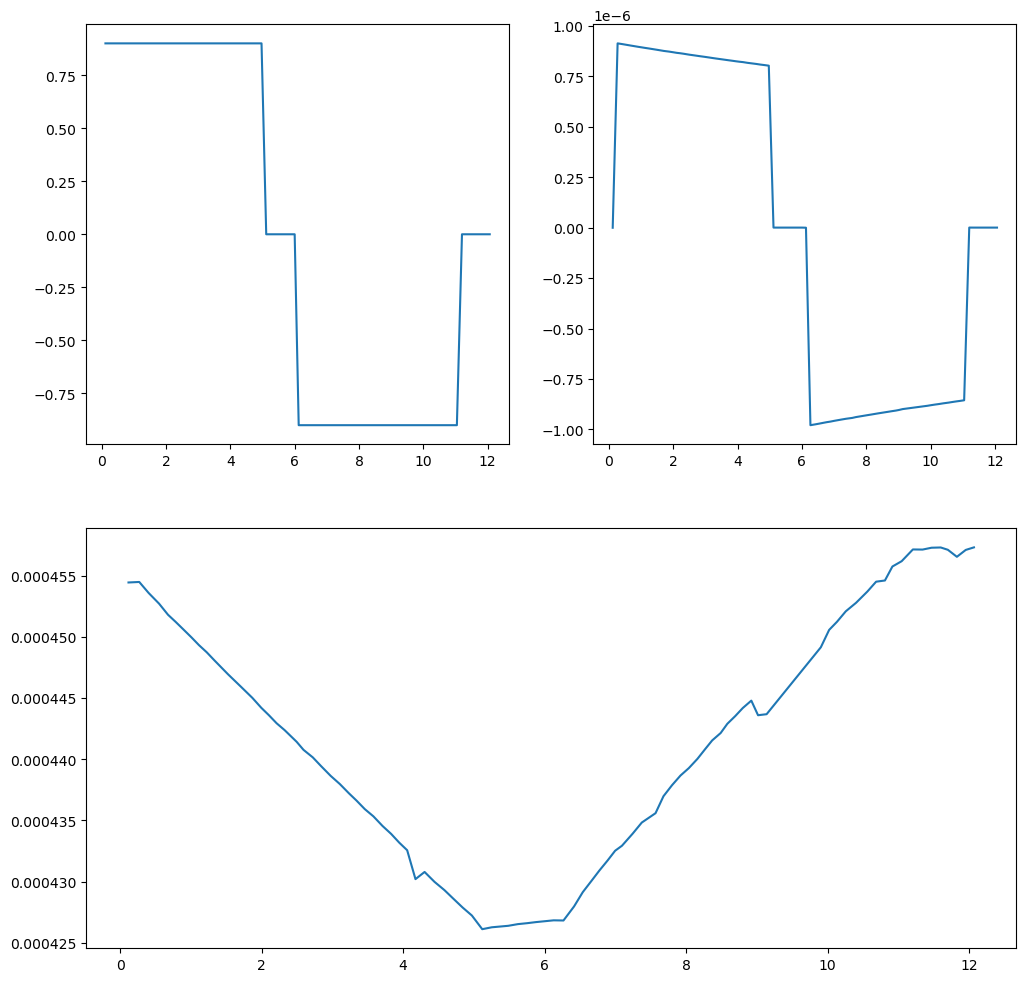

In [448]:
df = Load_Files([13])
df = df.drop(df[df['Time (s)']<0.001].index)
df = Group_Gate_Voltage(df)
df_Plot(df)

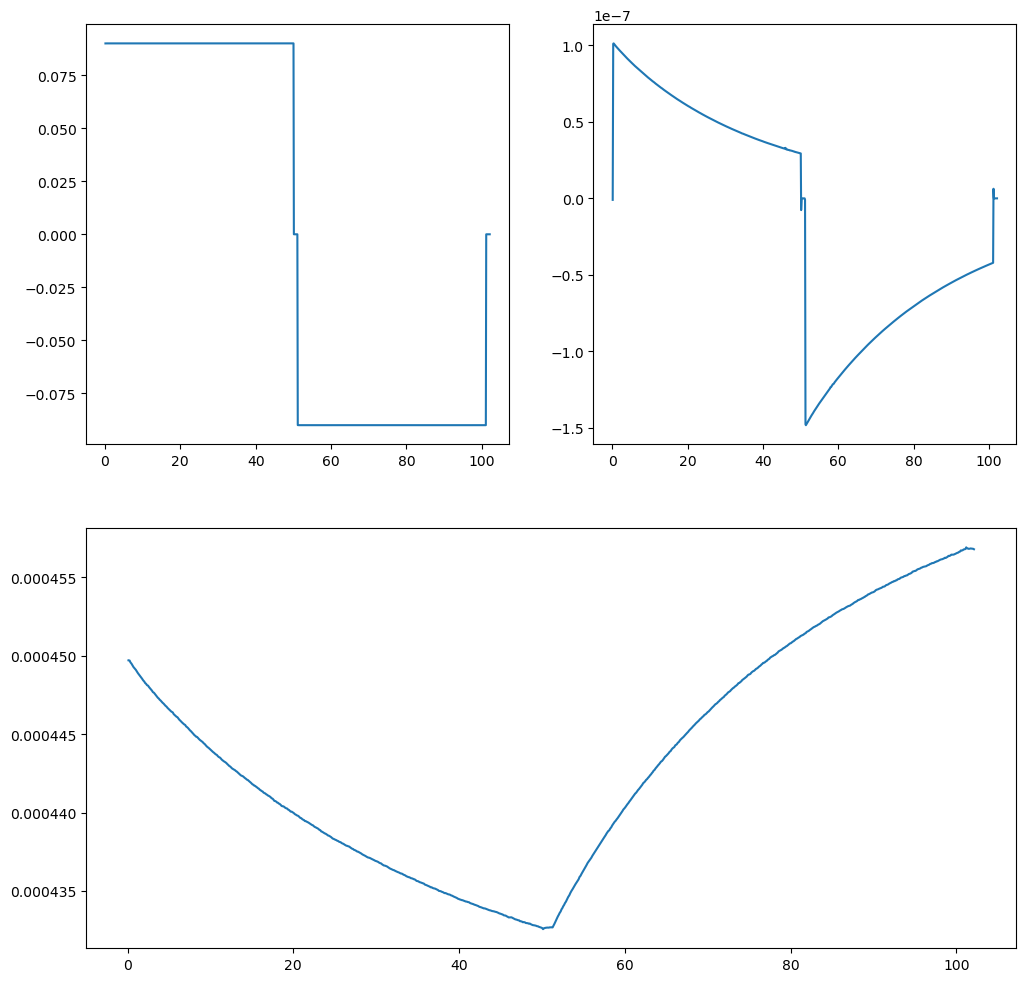

In [449]:
df = Load_Files([15])
df = Group_Gate_Voltage(df)
df_Plot(df)

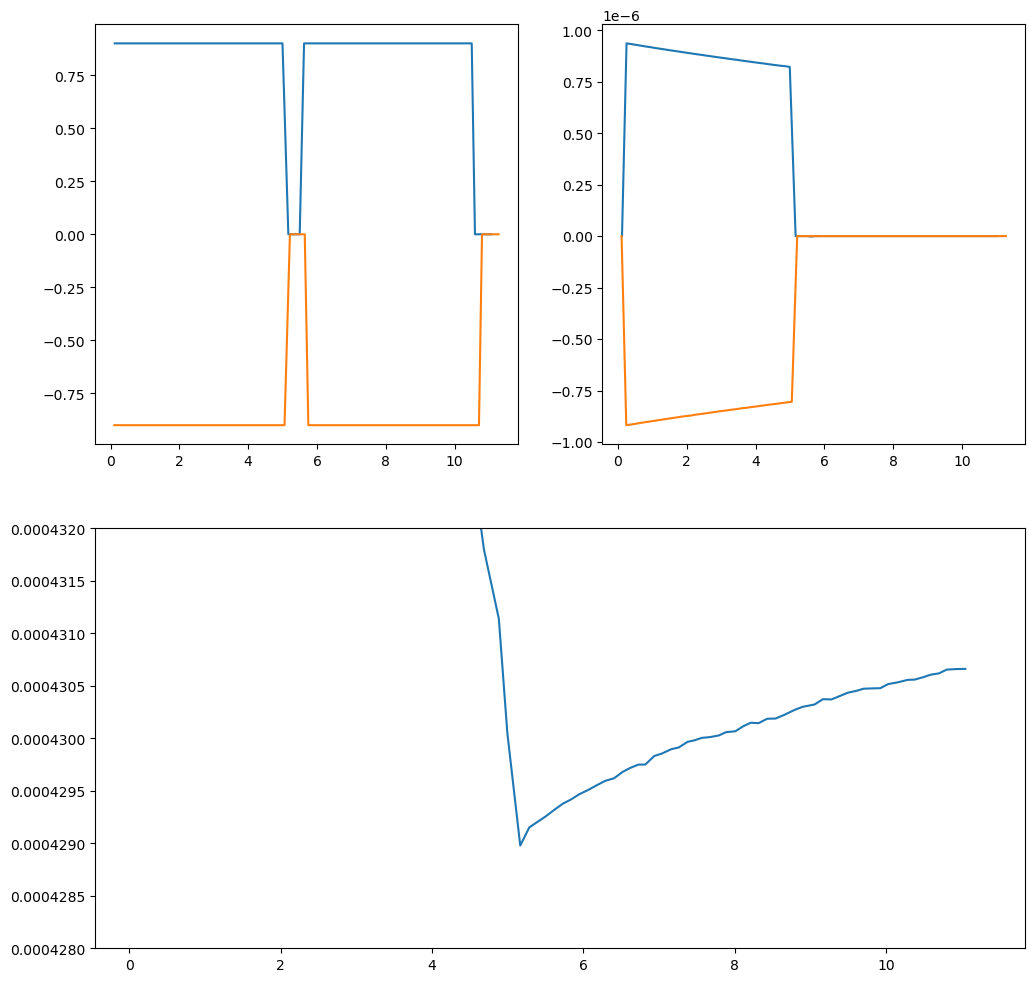

In [38]:
df = Load_Files([16, 18])
df = Group_Gate_Voltage(df)
df_Plot(df, y_range=(0.000428, 0.000432))

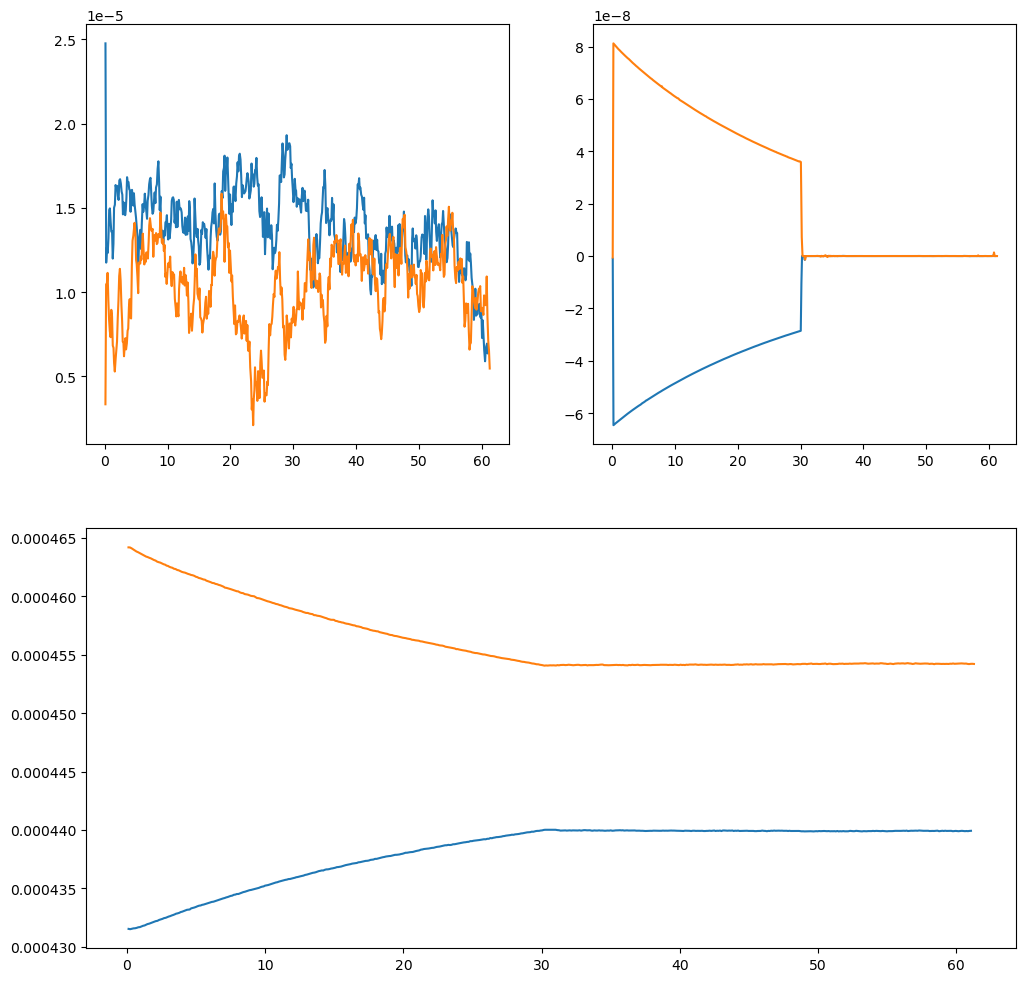

In [36]:
df = Load_Files([17, 19])
df = Group_Gate_Voltage(df)
df_Plot(df)